In [1]:
import pandas as pd
import numpy as np
import pyunpack
import math
import json

from data.data_download import Config, download_electricity
from data_formatters.electricity import ElectricityFormatter
from data_formatters.base import DataTypes, InputTypes

from data.custom_dataset import TFTDataset
from models import GatedLinearUnit
from models import GateAddNormNetwork
from models import GatedResidualNetwork 
from models import ScaledDotProductAttention
from models import InterpretableMultiHeadAttention
from models import VariableSelectionNetwork

from quantile_loss import QuantileLossCalculator
from quantile_loss import NormalizedQuantileLossCalculator

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import nn

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from argparse import ArgumentParser

import matplotlib.pyplot as plt

## Download Data

In [2]:
config = Config('data','data/electricity.csv')

In [3]:
download_electricity(config)

Pulling data from https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip to data/LD2011_2014.txt.zip
done
Unzipping file: data/LD2011_2014.txt.zip
Done.
Aggregating to hourly data
Processing MT_001
Processing MT_002
Processing MT_003
Processing MT_004
Processing MT_005
Processing MT_006
Processing MT_007
Processing MT_008
Processing MT_009
Processing MT_010
Processing MT_011
Processing MT_012
Processing MT_013
Processing MT_014
Processing MT_015
Processing MT_016
Processing MT_017
Processing MT_018
Processing MT_019
Processing MT_020
Processing MT_021
Processing MT_022
Processing MT_023
Processing MT_024
Processing MT_025
Processing MT_026
Processing MT_027
Processing MT_028
Processing MT_029
Processing MT_030
Processing MT_031
Processing MT_032
Processing MT_033
Processing MT_034
Processing MT_035
Processing MT_036
Processing MT_037
Processing MT_038
Processing MT_039
Processing MT_040
Processing MT_041
Processing MT_042
Processing MT_043
Processing MT_044

## Creating Datasets

In [2]:
electricity = pd.read_csv('data/electricity.csv', index_col = 0)
data_formatter = ElectricityFormatter()
train, valid, test = data_formatter.split_data(electricity)

/opt/conda/envs/nlp/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Formatting train-valid-test splits.
Setting scalers with training data...


In [3]:
train.shape, valid.shape, test.shape

((1923536, 13), (274536, 13), (123984, 13))

In [13]:
train.days_from_start.value_counts().to_frame().reset_index().sort_values(by=['index'])

,index,days_from_start
218,1096,8400
206,1097,8400
208,1098,8400
209,1099,8400
210,1100,8400
...,...,...
17,1310,8856
18,1311,8856
20,1312,8856
2,1313,8856


In [12]:
valid.days_from_start.value_counts().to_frame().reset_index().sort_values(by=['index'])

,index,days_from_start
30,1308,8856
2,1309,8856
3,1310,8856
4,1311,8856
5,1312,8856
6,1313,8856
7,1314,8856
8,1315,8856
9,1316,8856
10,1317,8856


In [11]:
test.days_from_start.value_counts().to_frame().reset_index().sort_values(by=['index'])

,index,days_from_start
11,1332,8856
10,1333,8856
9,1334,8856
8,1335,8856
7,1336,8856
6,1337,8856
5,1338,8856
4,1339,8856
3,1340,8856
2,1341,8856


### Reviewing Test dataset error

In [19]:
test = test.reset_index(drop=True)
test

,power_usage,t,days_from_start,categorical_id,date,id,hour,day,day_of_week,month,hours_from_start,categorical_day_of_week,categorical_hour
0,3.313606,31968.0,1332,0,2014-08-25 00:00:00,MT_001,-1.661325,25,-1.503741,8,2.001283,0,0
1,3.160683,31969.0,1332,0,2014-08-25 01:00:00,MT_001,-1.516862,25,-1.503741,8,2.001942,0,1
2,3.160683,31970.0,1332,0,2014-08-25 02:00:00,MT_001,-1.372399,25,-1.503741,8,2.002601,0,2
3,3.313606,31971.0,1332,0,2014-08-25 03:00:00,MT_001,-1.227936,25,-1.503741,8,2.003260,0,3
4,3.237144,31972.0,1332,0,2014-08-25 04:00:00,MT_001,-1.083473,25,-1.503741,8,2.003920,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
123979,0.929284,32299.0,1345,368,2014-09-07 19:00:00,MT_370,1.083473,7,1.508326,9,2.219437,6,19
123980,0.579135,32300.0,1345,368,2014-09-07 20:00:00,MT_370,1.227936,7,1.508326,9,2.220096,6,20
123981,0.761504,32301.0,1345,368,2014-09-07 21:00:00,MT_370,1.372399,7,1.508326,9,2.220755,6,21
123982,0.666672,32302.0,1345,368,2014-09-07 22:00:00,MT_370,1.516862,7,1.508326,9,2.221415,6,22


In [20]:
test[test.categorical_id == 0]

,power_usage,t,days_from_start,categorical_id,date,id,hour,day,day_of_week,month,hours_from_start,categorical_day_of_week,categorical_hour
0,3.313606,31968.0,1332,0,2014-08-25 00:00:00,MT_001,-1.661325,25,-1.503741,8,2.001283,0,0
1,3.160683,31969.0,1332,0,2014-08-25 01:00:00,MT_001,-1.516862,25,-1.503741,8,2.001942,0,1
2,3.160683,31970.0,1332,0,2014-08-25 02:00:00,MT_001,-1.372399,25,-1.503741,8,2.002601,0,2
3,3.313606,31971.0,1332,0,2014-08-25 03:00:00,MT_001,-1.227936,25,-1.503741,8,2.003260,0,3
4,3.237144,31972.0,1332,0,2014-08-25 04:00:00,MT_001,-1.083473,25,-1.503741,8,2.003920,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,3.237144,32299.0,1345,0,2014-09-07 19:00:00,MT_001,1.083473,7,1.508326,9,2.219437,6,19
332,0.025749,32300.0,1345,0,2014-09-07 20:00:00,MT_001,1.227936,7,1.508326,9,2.220096,6,20
333,1.325600,32301.0,1345,0,2014-09-07 21:00:00,MT_001,1.372399,7,1.508326,9,2.220755,6,21
334,3.237144,32302.0,1345,0,2014-09-07 22:00:00,MT_001,1.516862,7,1.508326,9,2.221415,6,22


In [31]:
test.groupby(['categorical_id']).apply(lambda x: x.shape[0]).mean()

336.0

In [21]:
g = test.groupby(['categorical_id'])

In [22]:
data_formatter.get_time_steps()

192

In [23]:
df_index_abs = g[['categorical_id']].transform(lambda x: x.index+data_formatter.get_time_steps()) \
                        .reset_index() \
                        .rename(columns={'index':'init_abs',
                                         'categorical_id':'end_abs'})
df_index_abs

,init_abs,end_abs
0,0,192
1,1,193
2,2,194
3,3,195
4,4,196
...,...,...
123979,123979,124171
123980,123980,124172
123981,123981,124173
123982,123982,124174


In [24]:
df_index_rel_init = g[['categorical_id']].transform(lambda x: x.reset_index(drop=True).index) \
                        .rename(columns={'categorical_id':'init_rel'})
df_index_rel_init

,init_rel
0,0
1,1
2,2
3,3
4,4
...,...
123979,331
123980,332
123981,333
123982,334


In [25]:
df_index_rel_end = g[['categorical_id']].transform(lambda x: x.reset_index(drop=True).index+data_formatter.get_time_steps()) \
                .rename(columns={'categorical_id':'end_rel'})
df_index_rel_end

,end_rel
0,192
1,193
2,194
3,195
4,196
...,...
123979,523
123980,524
123981,525
123982,526


In [26]:
336 - 192 + 1

145

In [27]:
df_total_count = g[['categorical_id']].transform(lambda x: x.shape[0] - data_formatter.get_time_steps() + 1) \
                .rename(columns = {'categorical_id':'group_count'})
df_total_count

,group_count
0,145
1,145
2,145
3,145
4,145
...,...
123979,145
123980,145
123981,145
123982,145


In [28]:
new_test = pd.concat([df_index_abs, 
                       df_index_rel_init,
                       df_index_rel_end,
                       test[['id']], 
                       df_total_count], axis = 1).reset_index(drop = True)
new_test

,init_abs,end_abs,init_rel,end_rel,id,group_count
0,0,192,0,192,MT_001,145
1,1,193,1,193,MT_001,145
2,2,194,2,194,MT_001,145
3,3,195,3,195,MT_001,145
4,4,196,4,196,MT_001,145
...,...,...,...,...,...,...
123979,123979,124171,331,523,MT_370,145
123980,123980,124172,332,524,MT_370,145
123981,123981,124173,333,525,MT_370,145
123982,123982,124174,334,526,MT_370,145


In [33]:
new_test[new_test.end_rel < test.groupby(['categorical_id']).apply(lambda x: x.shape[0]).mean()].reset_index()

,index,init_abs,end_abs,init_rel,end_rel,id,group_count
0,0,0,192,0,192,MT_001,145
1,1,1,193,1,193,MT_001,145
2,2,2,194,2,194,MT_001,145
3,3,3,195,3,195,MT_001,145
4,4,4,196,4,196,MT_001,145
...,...,...,...,...,...,...,...
53131,123787,123787,123979,139,331,MT_370,145
53132,123788,123788,123980,140,332,MT_370,145
53133,123789,123789,123981,141,333,MT_370,145
53134,123790,123790,123982,142,334,MT_370,145


## Loading Datasets

In [3]:
train_dataset = TFTDataset(train)
valid_dataset = TFTDataset(valid)
test_dataset = TFTDataset(test)

In [14]:
len(train_dataset), len(valid_dataset), len(test_dataset)

(1782209, 133209, 0)

In [5]:
len(train_dataset), len(valid_dataset), len(test_dataset)

(1841286, 203688, 53136)

In [29]:
test_dataset[0][0].shape, test_dataset[0][1].shape, test_dataset[0][2].shape

((192, 5), (24, 1), (24, 1))

## Temporal Fusion Transformer

In [4]:
class TemporalFusionTransformer(pl.LightningModule):
    def __init__(self, hparams):
        super(TemporalFusionTransformer, self).__init__()
        
        self.hparams = hparams
        
        self.name = self.__class__.__name__

        # Data parameters
        self.time_steps = int(hparams.total_time_steps)#int(params['total_time_steps'])
        self.input_size = int(hparams.input_size)#int(params['input_size'])
        self.output_size = int(hparams.output_size)#int(params['output_size'])
        self.category_counts = json.loads(str(hparams.category_counts))#json.loads(str(params['category_counts']))
        self.num_categorical_variables = len(self.category_counts)
        self.num_regular_variables = self.input_size - self.num_categorical_variables
        self.n_multiprocessing_workers = int(hparams.multiprocessing_workers) #int(params['multiprocessing_workers'])

        # Relevant indices for TFT
        self._input_obs_loc = json.loads(str(hparams.input_obs_loc))#json.loads(str(params['input_obs_loc']))
        self._static_input_loc = json.loads(str(hparams.static_input_loc))#json.loads(str(params['static_input_loc']))
        self._known_regular_input_idx = json.loads(str(hparams.known_regular_inputs))#json.loads(str(params['known_regular_inputs']))
        self._known_categorical_input_idx = json.loads(str(hparams.known_categorical_inputs))#json.loads(str(params['known_categorical_inputs']))
        
        self.num_non_static_historical_inputs = self.get_historical_num_inputs()
        self.num_non_static_future_inputs = self.get_future_num_inputs()
        
        self.column_definition = [
                                  ('id', DataTypes.REAL_VALUED, InputTypes.ID),
                                  ('hours_from_start', DataTypes.REAL_VALUED, InputTypes.TIME),
                                  ('power_usage', DataTypes.REAL_VALUED, InputTypes.TARGET),
                                  ('hour', DataTypes.REAL_VALUED, InputTypes.KNOWN_INPUT),
                                  ('day_of_week', DataTypes.REAL_VALUED, InputTypes.KNOWN_INPUT),
                                  ('hours_from_start', DataTypes.REAL_VALUED, InputTypes.KNOWN_INPUT),
                                  ('categorical_id', DataTypes.CATEGORICAL, InputTypes.STATIC_INPUT),
                                ]

        # Network params
        self.quantiles = [0.1, 0.5, 0.9]
#         self.use_cudnn = use_cudnn  # Whether to use GPU optimised LSTM
        self.hidden_layer_size = int(hparams.hidden_layer_size)#int(params['hidden_layer_size'])
        self.dropout_rate = float(hparams.dropout_rate)#float(params['dropout_rate'])
        self.max_gradient_norm = float(hparams.max_gradient_norm)#float(params['max_gradient_norm'])
        self.learning_rate = float(hparams.learning_rate)#float(params['learning_rate'])
        self.minibatch_size = int(hparams.minibatch_size)#int(params['minibatch_size'])
        self.num_epochs = int(hparams.num_epochs)#int(params['num_epochs'])
        self.early_stopping_patience = int(hparams.early_stopping_patience)#int(params['early_stopping_patience'])

        self.num_encoder_steps = int(hparams.num_encoder_steps)#int(params['num_encoder_steps'])
        self.num_stacks = int(hparams.stack_size)#int(params['stack_size'])
        self.num_heads = int(hparams.num_heads)#int(params['num_heads'])

        # Serialisation options
#         self._temp_folder = os.path.join(params['model_folder'], 'tmp')
#         self.reset_temp_folder()

        # Extra components to store Tensorflow nodes for attention computations
        self._input_placeholder = None
        self._attention_components = None
        self._prediction_parts = None

        print('*** {} params ***'.format(self.name))
        for k in vars(hparams):
            print('# {} = {}'.format(k, vars(hparams)[k]))
            
        self.train_criterion = QuantileLossCalculator(self.quantiles, self.output_size)
        self.test_criterion = NormalizedQuantileLossCalculator(self.quantiles, self.output_size)

        # Build model
        ## Build embeddings
        self.build_embeddings()
        
        ## Build Static Contex Networks
        self.build_static_context_networks()
        
        ## Building Variable Selection Networks
        self.build_variable_selection_networks()
        
        ## Build Lstm
        self.build_lstm()
        
        ## Build GLU for after lstm encoder decoder and layernorm
        self.build_post_lstm_gate_add_norm()
        
        ## Build Static Enrichment Layer
        self.build_static_enrichment()
        
        ## Building decoder multihead attention
        self.build_temporal_self_attention()
        
        ## Building positionwise decoder
        self.build_position_wise_feed_forward()
        
        ## Build output feed forward
        self.build_output_feed_forward()
        
        ## Initializing remaining weights
        self.init_weights()
        
    def init_weights(self):
        for name, p in self.named_parameters():
            if ('lstm' in name and 'ih' in name) and 'bias' not in name:
                #print(name)
                #print(p.shape)
                torch.nn.init.xavier_uniform_(p)
#                 torch.nn.init.kaiming_normal_(p, a=0, mode='fan_in', nonlinearity='sigmoid')
            elif ('lstm' in name and 'hh' in name) and 'bias' not in name:
        
                 torch.nn.init.orthogonal_(p)
            
            elif 'lstm' in name and 'bias' in name:
                #print(name)
                #print(p.shape)
                torch.nn.init.zeros_(p)
        
    def get_historical_num_inputs(self):
        
        obs_inputs = [i for i in self._input_obs_loc]
        
        known_regular_inputs = [i for i in self._known_regular_input_idx
                                if i not in self._static_input_loc]
            
        known_categorical_inputs = [i for i in self._known_categorical_input_idx
                                    if i + self.num_regular_variables not in self._static_input_loc]
        
        wired_embeddings = [i for i in range(self.num_categorical_variables)
                            if i not in self._known_categorical_input_idx 
                            and i not in self._input_obs_loc]

        unknown_inputs = [i for i in range(self.num_regular_variables)
                          if i not in self._known_regular_input_idx
                          and i not in self._input_obs_loc]

        return len(obs_inputs+known_regular_inputs+known_categorical_inputs+wired_embeddings+unknown_inputs)
    
    def get_future_num_inputs(self):
            
        known_regular_inputs = [i for i in self._known_regular_input_idx
                                if i not in self._static_input_loc]
            
        known_categorical_inputs = [i for i in self._known_categorical_input_idx
                                    if i + self.num_regular_variables not in self._static_input_loc]

        return len(known_regular_inputs + known_categorical_inputs)
    
    def build_embeddings(self):
        self.categorical_var_embeddings = nn.ModuleList([nn.Embedding(self.category_counts[i], 
                                                                      self.hidden_layer_size) 
                                                     for i in range(self.num_categorical_variables)])

        self.regular_var_embeddings = nn.ModuleList([nn.Linear(1, 
                                                              self.hidden_layer_size) 
                                                  for i in range(self.num_regular_variables)])

    def build_variable_selection_networks(self):
        
        self.static_vsn = VariableSelectionNetwork(hidden_layer_size = self.hidden_layer_size,
                                                   input_size = self.hidden_layer_size * len(self._static_input_loc),
                                                   output_size = len(self._static_input_loc),
                                                   dropout_rate = self.dropout_rate)
        
        self.temporal_historical_vsn = VariableSelectionNetwork(hidden_layer_size = self.hidden_layer_size,
                                                                input_size = self.hidden_layer_size *
                                                                        self.num_non_static_historical_inputs,
                                                                output_size = self.num_non_static_historical_inputs,
                                                                dropout_rate = self.dropout_rate,
                                                                additional_context=self.hidden_layer_size)
        
        self.temporal_future_vsn = VariableSelectionNetwork(hidden_layer_size = self.hidden_layer_size,
                                                            input_size = self.hidden_layer_size *
                                                                        self.num_non_static_future_inputs,
                                                            output_size = self.num_non_static_future_inputs,
                                                            dropout_rate = self.dropout_rate,
                                                            additional_context=self.hidden_layer_size)
        
    def build_static_context_networks(self):
        
        self.static_context_variable_selection_grn = GatedResidualNetwork(self.hidden_layer_size,
                                                                          dropout_rate=self.dropout_rate)
        
        self.static_context_enrichment_grn = GatedResidualNetwork(self.hidden_layer_size,
                                                              dropout_rate=self.dropout_rate)

        self.static_context_state_h_grn = GatedResidualNetwork(self.hidden_layer_size,
                                                           dropout_rate=self.dropout_rate)
        
        self.static_context_state_c_grn = GatedResidualNetwork(self.hidden_layer_size,
                                                           dropout_rate=self.dropout_rate)
        
    def build_lstm(self):
        self.historical_lstm = nn.LSTM(input_size = self.hidden_layer_size,
                                       hidden_size = self.hidden_layer_size,
                                       batch_first = True)
        self.future_lstm = nn.LSTM(input_size = self.hidden_layer_size,
                                   hidden_size = self.hidden_layer_size,
                                   batch_first = True)
        
    def build_post_lstm_gate_add_norm(self):
        self.post_seq_encoder_gate_add_norm = GateAddNormNetwork(self.hidden_layer_size,
                                                                 self.hidden_layer_size,
                                                                 self.dropout_rate,
                                                                 activation = None)
        
    def build_static_enrichment(self):
        self.static_enrichment = GatedResidualNetwork(self.hidden_layer_size,
                                                      dropout_rate = self.dropout_rate,
                                                      additional_context=self.hidden_layer_size)
        
    def build_temporal_self_attention(self):
        self.self_attn_layer = InterpretableMultiHeadAttention(n_head = self.num_heads, 
                                                               d_model = self.hidden_layer_size,
                                                               dropout = self.dropout_rate)
        
        self.post_attn_gate_add_norm = GateAddNormNetwork(self.hidden_layer_size,
                                                           self.hidden_layer_size,
                                                           self.dropout_rate,
                                                           activation = None)
        
    def build_position_wise_feed_forward(self):
        self.GRN_positionwise = GatedResidualNetwork(self.hidden_layer_size,
                                                     dropout_rate = self.dropout_rate)
        
        self.post_tfd_gate_add_norm = GateAddNormNetwork(self.hidden_layer_size,
                                                         self.hidden_layer_size,
                                                         self.dropout_rate,
                                                         activation = None)
        
    def build_output_feed_forward(self):
        self.output_feed_forward = torch.nn.Linear(self.hidden_layer_size, 
                                                   self.output_size * len(self.quantiles))
         
    def get_decoder_mask(self, self_attn_inputs):
        """Returns causal mask to apply for self-attention layer.
        Args:
        self_attn_inputs: Inputs to self attention layer to determine mask shape
        """
        len_s = self_attn_inputs.shape[1]
        bs = self_attn_inputs.shape[0]
        mask = torch.cumsum(torch.eye(len_s), 0)
        mask = mask.repeat(bs,1,1).to(torch.float32)

        return mask#.to(DEVICE)
    
    def get_tft_embeddings(self, regular_inputs, categorical_inputs):
        # Static input
        if self._static_input_loc:
            static_regular_inputs = [self.regular_var_embeddings[i](regular_inputs[:, 0, i:i + 1]) 
                                    for i in range(self.num_regular_variables)
                                    if i in self._static_input_loc]
            #print('static_regular_inputs')
            #print([print(emb.shape) for emb in static_regular_inputs])
            
            static_categorical_inputs = [self.categorical_var_embeddings[i](categorical_inputs[Ellipsis, i])[:,0,:] 
                                         for i in range(self.num_categorical_variables)
                                         if i + self.num_regular_variables in self._static_input_loc]
            #print('static_categorical_inputs')
            #print([print(emb.shape) for emb in static_categorical_inputs])
            static_inputs = torch.stack(static_regular_inputs + static_categorical_inputs, axis = 1)
        else:
            static_inputs = None
            
        # Target input
        obs_inputs = torch.stack([self.regular_var_embeddings[i](regular_inputs[Ellipsis, i:i + 1])
                                     for i in self._input_obs_loc], axis=-1)
        
        # Observed (a prioir unknown) inputs
        wired_embeddings = []
        for i in range(self.num_categorical_variables):
            if i not in self._known_categorical_input_idx \
            and i not in self._input_obs_loc:
                e = self.categorical_var_embeddings[i](categorical_inputs[:, :, i])
                wired_embeddings.append(e)

        unknown_inputs = []
        for i in range(self.num_regular_variables):
            if i not in self._known_regular_input_idx \
            and i not in self._input_obs_loc:
                e = self.regular_var_embeddings[i](regular_inputs[Ellipsis, i:i + 1])
                unknown_inputs.append(e)
                
        if unknown_inputs + wired_embeddings:
            unknown_inputs = torch.stack(unknown_inputs + wired_embeddings, axis=-1)
        else:
            unknown_inputs = None
            
        # A priori known inputs
        known_regular_inputs = [self.regular_var_embeddings[i](regular_inputs[Ellipsis, i:i + 1])
                                for i in self._known_regular_input_idx
                                if i not in self._static_input_loc]
        #print('known_regular_inputs')
        #print([print(emb.shape) for emb in known_regular_inputs])
        
        known_categorical_inputs = [self.categorical_var_embeddings[i](categorical_inputs[Ellipsis, i])
                                    for i in self._known_categorical_input_idx
                                    if i + self.num_regular_variables not in self._static_input_loc]
       #print('known_categorical_inputs')
       #print([print(emb.shape) for emb in known_categorical_inputs])

        known_combined_layer = torch.stack(known_regular_inputs + known_categorical_inputs, axis=-1)
        
        return unknown_inputs, known_combined_layer, obs_inputs, static_inputs
        
    def forward(self, all_inputs):

        regular_inputs = all_inputs[:, :, :self.num_regular_variables].to(torch.float)
        #print('regular_inputs')
        #print(regular_inputs.shape)
        categorical_inputs = all_inputs[:, :, self.num_regular_variables:].to(torch.long)
        #print('categorical_inputs')
        #print(categorical_inputs.shape)
        
        unknown_inputs, known_combined_layer, obs_inputs, static_inputs \
            = self.get_tft_embeddings(regular_inputs, categorical_inputs)
        
        # Isolate known and observed historical inputs.
        if unknown_inputs is not None:
              historical_inputs = torch.cat([
                  unknown_inputs[:, :self.num_encoder_steps, :],
                  known_combined_layer[:, :self.num_encoder_steps, :],
                  obs_inputs[:, :self.num_encoder_steps, :]
              ], axis=-1)
        else:
              historical_inputs = torch.cat([
                  known_combined_layer[:, :self.num_encoder_steps, :],
                  obs_inputs[:, :self.num_encoder_steps, :]
              ], axis=-1)
                
        #print('historical_inputs')
        #print(historical_inputs.shape)
        
        # Isolate only known future inputs.
        future_inputs = known_combined_layer[:, self.num_encoder_steps:, :]
        #print('future_inputs')
        #print(future_inputs.shape)
              
        #print('static_inputs')
        #print(static_inputs.shape)
        
        static_encoder, sparse_weights = self.static_vsn(static_inputs)
        
        #print('static_encoder')
        #print(static_encoder.shape)
        
        #print('sparse_weights')
        #print(sparse_weights.shape)
        
        static_context_variable_selection = self.static_context_variable_selection_grn(static_encoder)
        #print('static_context_variable_selection')
        #print(static_context_variable_selection.shape)
        static_context_enrichment = self.static_context_enrichment_grn(static_encoder)
        #print('static_context_enrichment')
        #print(static_context_enrichment.shape)
        static_context_state_h = self.static_context_state_h_grn(static_encoder)
        #print('static_context_state_h')
        #print(static_context_state_h.shape)
        static_context_state_c = self.static_context_state_c_grn(static_encoder)
        #print('static_context_state_c')
        #print(static_context_state_c.shape)
        
        historical_features, historical_flags \
        = self.temporal_historical_vsn((historical_inputs,
                                        static_context_variable_selection))
        #print('historical_features')
        #print(historical_features.shape)
        #print('historical_flags')
        #print(historical_flags.shape)
        
        future_features, future_flags \
        = self.temporal_future_vsn((future_inputs,
                                    static_context_variable_selection))
        #print('future_features')
        #print(future_features.shape)
        #print('future_flags')
        #print(future_flags.shape)
        
        history_lstm, (state_h, state_c) \
        = self.historical_lstm(historical_features,
                               (static_context_state_h.unsqueeze(0),
                                static_context_state_c.unsqueeze(0)))
        #print('history_lstm')
        #print(history_lstm.shape)
        #print('state_h')
        #print(state_h.shape)
        #print('state_c')
        #print(state_c.shape)
        
        future_lstm, _ = self.future_lstm(future_features,
                                          (state_h,
                                           state_c))
        #print('future_lstm')
        #print(future_lstm.shape)
        
        # Apply gated skip connection
        input_embeddings = torch.cat((historical_features, future_features), axis=1)
        #print('input_embeddings')
        #print(input_embeddings.shape) 
        
        lstm_layer = torch.cat((history_lstm, future_lstm), axis=1)
        #print('lstm_layer')
        #print(lstm_layer.shape) 
        
        temporal_feature_layer = self.post_seq_encoder_gate_add_norm(lstm_layer, input_embeddings)
        #print('temporal_feature_layer')
        #print(temporal_feature_layer.shape)  
        
        # Static enrichment layers
        expanded_static_context = static_context_enrichment.unsqueeze(1)
        
        enriched = self.static_enrichment((temporal_feature_layer, expanded_static_context))
        #print('enriched')
        #print(enriched.shape)    
        
        # Decoder self attention
        #self.mask = self.get_decoder_mask(enriched)
        #print('enriched')
        #print(enriched.shape)
        x, self_att = self.self_attn_layer(enriched, 
                                           enriched, 
                                           enriched,
                                           mask = self.get_decoder_mask(enriched))
        #print('x')
        #print(x.shape)
        #print('self_att')
        #print(self_att.shape)
        
        x = self.post_attn_gate_add_norm(x, enriched)
        #print('x')
        #print(x.shape)
        
        # Nonlinear processing on outputs
        decoder = self.GRN_positionwise(x)
        #print('decoder')
        #print(decoder.shape)
        
        # Final skip connection
        transformer_layer = self.post_tfd_gate_add_norm(decoder, temporal_feature_layer)
        #print('transformer_layer')
        #print(transformer_layer.shape)
        
        outputs = self.output_feed_forward(transformer_layer[Ellipsis, self.num_encoder_steps:, :])
        #print('outputs')
        #print(outputs.shape)
        
        #ipdb.set_trace()
        
        return outputs
    
    def loss(self, y_hat, y):
        return self.train_criterion.apply(y_hat, y)
    
    def test_loss(self, y_hat, y):
        return self.test_criterion.apply(y_hat, y, self.quantiles[1])
    
    def training_step(self, batch, batch_nb):
        x, y, _ = batch
        
        x = x.to(torch.float)
        y = y.to(torch.float)
#         print('y')
#         print(y.shape)
        y_hat = self.forward(x)
#         print('y_hat')
#         print(y_hat.shape)
        loss = self.loss(y_hat, torch.cat([y, y, y], dim = -1))
        #print(loss.shape)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}
    
    def validation_step(self, batch, batch_nb):
        x, y, _ = batch
        x = x.to(torch.float)
        y = y.to(torch.float)
        y_hat = self.forward(x)
        #print(y_hat.shape)
        #print(torch.cat([y, y, y], dim = -1).shape)
        loss = self.loss(y_hat, torch.cat([y, y, y], dim = -1))
        #print(loss)
        return {'val_loss': loss}
    
    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}
    
    def test_step(self, batch, batch_idx):
        # OPTIONAL
        x, y, _ = batch
        x = x.to(torch.float)
        y = y.to(torch.float)
        y_hat = self.forward(x)
        return {'test_loss': self.test_loss(y_hat[Ellipsis, 1], y[Ellipsis, 0])}

    def test_end(self, outputs):
        # OPTIONAL
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        tensorboard_logs = {'test_loss': avg_loss}
        return {'avg_test_loss': avg_loss, 'log': tensorboard_logs}
    
    def configure_optimizers(self):
        # REQUIRED
        # can return multiple optimizers and learning_rate schedulers
        # (LBFGS it is automatically supported, no need for closure function)
        return [torch.optim.Adam(self.parameters(), lr=self.learning_rate)]
    
    def plot_grad_flow(self, named_parameters):
        ave_grads = []
        layers = []
        for name, p in named_parameters:
            if p.grad is not None:
                if (p.requires_grad) and ("bias" not in name):
                    layers.append(name)
                    ave_grads.append(p.grad.abs().mean())
                    self.logger.experiment.add_histogram(tag=name, values=p.grad,
                                                         global_step=self.trainer.global_step)
            else:
                 print('{} - {}'.format(name, p.requires_grad))
            
        plt.plot(ave_grads, alpha=0.3, color="b")
        plt.hlines(0, 0, len(ave_grads), linewidth=1, color="k" )
        plt.xticks(list(range(0,len(ave_grads), 1)), layers, rotation='vertical')
        plt.xlim(left=0, right=len(ave_grads))
        plt.xlabel("Layers")
        plt.ylabel("average gradient")
        plt.title("Gradient flow")
        plt.grid(True)
        plt.rcParams["figure.figsize"] = (20, 5)
    
    def on_after_backward(self):
        # example to inspect gradient information in tensorboard
        if self.trainer.global_step % 25 == 0:  
            self.plot_grad_flow(self.named_parameters())
    
    def train_dataloader(self):
        # REQUIRED
        return DataLoader(train_dataset, batch_size = self.minibatch_size, shuffle=True, drop_last=True)

    def val_dataloader(self):
        # OPTIONAL
        return DataLoader(valid_dataset, batch_size = self.minibatch_size, shuffle=True, drop_last=True)
    
    def test_dataloader(self):
        # OPTIONAL
        return DataLoader(test_dataset, batch_size = self.minibatch_size, shuffle=True, drop_last=True)

## Training

### Setting Device

In [5]:
DEVICE = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

### Input Parameters

In [6]:
params = data_formatter.get_experiment_params()
params.update(data_formatter.get_default_model_params())

parser = ArgumentParser(add_help=False)

In [7]:
for k in params:
    if type(params[k]) in [int, float]:
        #if k == 'minibatch_size':
        #    parser.add_argument('--{}'.format(k), type=type(params[k]), default = 256)
        #else:
        parser.add_argument('--{}'.format(k), type=type(params[k]), default = params[k])
    else:
        parser.add_argument('--{}'.format(k), type=str, default = str(params[k]))
hparams = parser.parse_known_args()[0]

### Model Instance

In [8]:
tft = TemporalFusionTransformer(hparams)#.to(DEVICE)
tft

*** TemporalFusionTransformer params ***
# total_time_steps = 192
# num_encoder_steps = 168
# num_epochs = 100
# early_stopping_patience = 5
# multiprocessing_workers = 5
# column_definition = [('id', <DataTypes.REAL_VALUED: 0>, <InputTypes.ID: 4>), ('hours_from_start', <DataTypes.REAL_VALUED: 0>, <InputTypes.TIME: 5>), ('power_usage', <DataTypes.REAL_VALUED: 0>, <InputTypes.TARGET: 0>), ('hour', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('day_of_week', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('hours_from_start', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('categorical_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.STATIC_INPUT: 3>)]
# input_size = 5
# output_size = 1
# category_counts = [369]
# input_obs_loc = [0]
# static_input_loc = [4]
# known_regular_inputs = [1, 2, 3]
# known_categorical_inputs = [0]
# dropout_rate = 0.1
# hidden_layer_size = 160
# learning_rate = 0.001
# minibatch_size = 64
# max_gradient_norm = 0.01
# num_heads = 4

TemporalFusionTransformer(
  (categorical_var_embeddings): ModuleList(
    (0): Embedding(369, 160)
  )
  (regular_var_embeddings): ModuleList(
    (0): Linear(in_features=1, out_features=160, bias=True)
    (1): Linear(in_features=1, out_features=160, bias=True)
    (2): Linear(in_features=1, out_features=160, bias=True)
    (3): Linear(in_features=1, out_features=160, bias=True)
  )
  (static_context_variable_selection_grn): GatedResidualNetwork(
    (W1): Linear(in_features=160, out_features=160, bias=True)
    (W2): Linear(in_features=160, out_features=160, bias=True)
    (glu_add_norm): GateAddNormNetwork(
      (GLU): GatedLinearUnit(
        (dropout): Dropout(p=0.1, inplace=False)
        (W4): Linear(in_features=160, out_features=160, bias=True)
        (W5): Linear(in_features=160, out_features=160, bias=True)
        (sigmoid): Sigmoid()
      )
      (LayerNorm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
    )
  )
  (static_context_enrichment_grn): GatedResidual

In [18]:
early_stop_callback = EarlyStopping(monitor = 'val_loss',
                                    min_delta = 1e-4,
                                    patience = tft.early_stopping_patience,
                                    verbose=False,
                                    mode='min')

1

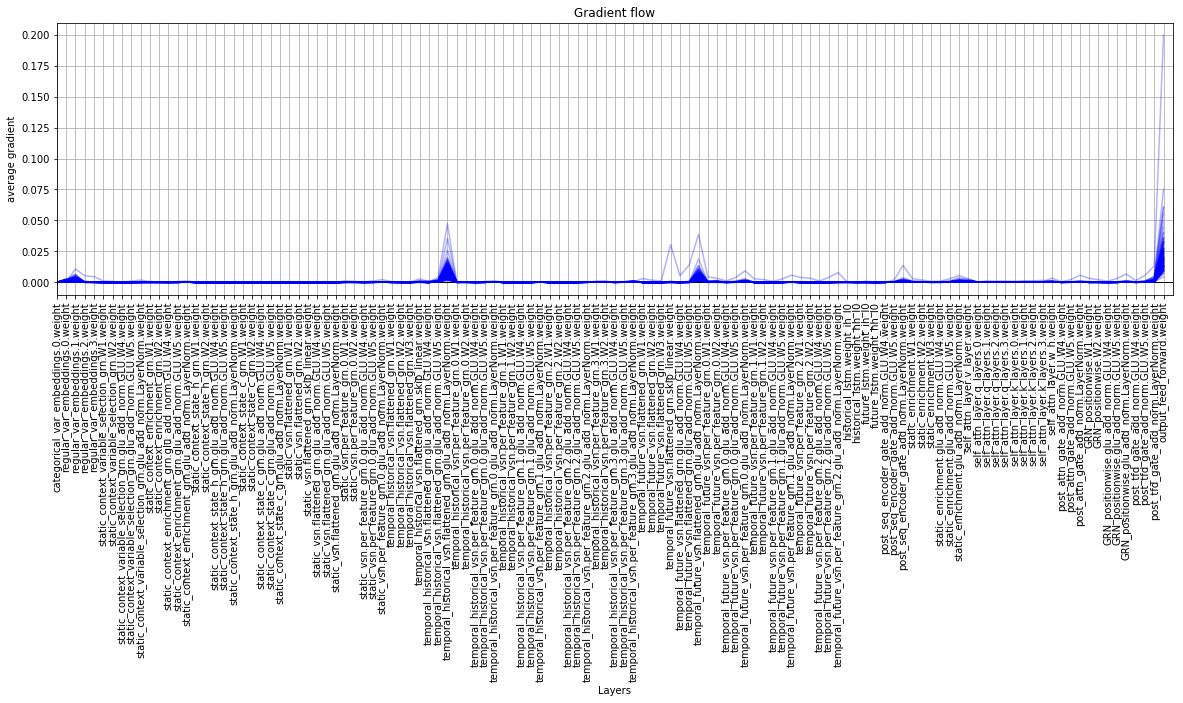

In [19]:
trainer = pl.Trainer(max_nb_epochs = tft.num_epochs,
                     gpus = 1, 
                     track_grad_norm = 2, 
                     gradient_clip_val = tft.max_gradient_norm,
                     early_stop_callback = early_stop_callback,
                     #train_percent_check = 0.01,
                     #val_percent_check = 0.01,
                     #test_percent_check = 0.01,
                     overfit_pct=0.01,
                     #fast_dev_run=True,
                     #profiler=True,
                     #print_nan_grads = True,
                     #distributed_backend='dp'
                    )    
trainer.fit(tft)

In [20]:
trainer.test()

----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



### Testing

In [3]:
!pwd

/home/daniel/github/temporal_fusion_transformer_pytorch


In [9]:
model = tft.load_from_metrics(
                             weights_path='lightning_logs/version_18/checkpoints/epoch=6.ckpt',
                             tags_csv='lightning_logs/version_18/meta_tags.csv',
                             #on_gpu=True,
                             map_location=None
                            )

*** TemporalFusionTransformer params ***
# total_time_steps = 192
# num_encoder_steps = 168
# num_epochs = 100
# early_stopping_patience = 5
# multiprocessing_workers = 5
# column_definition = [('id', <DataTypes.REAL_VALUED: 0>, <InputTypes.ID: 4>), ('hours_from_start', <DataTypes.REAL_VALUED: 0>, <InputTypes.TIME: 5>), ('power_usage', <DataTypes.REAL_VALUED: 0>, <InputTypes.TARGET: 0>), ('hour', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('day_of_week', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('hours_from_start', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('categorical_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.STATIC_INPUT: 3>)]
# input_size = 5
# output_size = 1
# category_counts = [369]
# input_obs_loc = [0]
# static_input_loc = [4]
# known_regular_inputs = [1, 2, 3]
# known_categorical_inputs = [0]
# dropout_rate = 0.1
# hidden_layer_size = 160
# learning_rate = 0.001
# minibatch_size = 64
# max_gradient_norm = 0.01
# num_heads = 4

In [10]:
q_risk = NormalizedQuantileLossCalculator([0.1, 0.5, 0.9], 1)
test_dataloader = DataLoader(test_dataset, batch_size = 64, shuffle=True, drop_last=True)

In [11]:
loss = []
batches = 0
for i, (batch, target, _ )in enumerate(test_dataloader):
    if i < 5:
        t = target
        batches += 1
        output = tft(batch)
        loss.append(q_risk.apply(output[Ellipsis, 1], target[Ellipsis, 0], 0.5))
    else:
        break
mean_loss = sum(loss) / batches
mean_loss

tensor(2., dtype=torch.float64, grad_fn=<DivBackward0>)

In [24]:
loss

[tensor(2., dtype=torch.float64, grad_fn=<DivBackward0>)]

In [21]:
output[Ellipsis, 1:2].shape

torch.Size([64, 24, 1])

In [17]:
t.shape, output.shape

(torch.Size([64, 24, 1]), torch.Size([64, 24, 3]))

## Testing implementation

In [3]:
def get_decoder_mask(self_attn_inputs):
    """Returns causal mask to apply for self-attention layer.
    Args:
    self_attn_inputs: Inputs to self attention layer to determine mask shape
    """
    len_s = self_attn_inputs.shape[1]
    bs = self_attn_inputs.shape[0]
    mask = torch.cumsum(torch.eye(len_s), 0)
    mask = mask.repeat(bs,1,1).to(torch.float32)

    return mask

In [14]:
a = torch.randn((2,6,4))
a

tensor([[[ 0.4701, -0.5985, -0.9775,  0.3386],
         [-0.6160, -0.3554,  0.8719,  2.0412],
         [ 1.3902,  2.1303, -1.2918,  0.5983],
         [ 1.0158,  0.5428,  0.8793,  0.9450],
         [-0.0350,  0.8870, -1.7651, -0.4571],
         [-0.8908,  0.1620, -1.3613, -0.4487]],

        [[-0.7297, -0.7173,  0.5279, -0.0354],
         [ 0.9267, -1.7141,  2.7410, -0.5471],
         [ 0.1380, -0.8149,  1.9545, -0.3068],
         [-0.6078,  1.2512,  0.1963, -0.5023],
         [ 0.0187, -0.2740,  0.8720,  1.1292],
         [ 1.2788,  0.0790, -0.9275, -0.1276]]])

In [15]:
mask = get_decoder_mask(a)
mask

tensor([[[1., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 1., 0.],
         [1., 1., 1., 1., 1., 1.]],

        [[1., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 1., 0.],
         [1., 1., 1., 1., 1., 1.]]])

In [6]:
mask.shape

torch.Size([2, 6, 6])

In [7]:
linear = nn.Linear(4, 2, bias = False)

In [8]:
a_lin = linear(a)
a_lin.shape

torch.Size([2, 6, 2])

In [16]:
to_attn = torch.bmm(a_lin, a_lin.permute(0,2,1))

In [18]:
masked_attn = to_attn.masked_fill(mask == 0, -1e9)
masked_attn

tensor([[[ 4.9358e-01, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09,
          -1.0000e+09],
         [ 6.6717e-01,  2.3156e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09,
          -1.0000e+09],
         [ 6.1026e-02, -2.8282e-01,  1.0194e-01, -1.0000e+09, -1.0000e+09,
          -1.0000e+09],
         [ 4.5336e-01,  9.2999e-01, -2.5902e-02,  4.8758e-01, -1.0000e+09,
          -1.0000e+09],
         [-1.9531e-01, -7.7465e-01,  1.0780e-01, -2.9396e-01,  2.6173e-01,
          -1.0000e+09],
         [ 9.6977e-03,  7.2699e-01, -1.8326e-01,  1.6906e-01, -2.6169e-01,
           3.6066e-01]],

        [[ 1.0421e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09,
          -1.0000e+09],
         [-1.4668e-02,  1.8592e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09,
          -1.0000e+09],
         [-4.1870e-01, -1.8913e-01,  1.8869e-01, -1.0000e+09, -1.0000e+09,
          -1.0000e+09],
         [-1.6112e+00,  2.2147e+00,  4.1740e-01,  5.0758e+00, -1.0000e+09,
          -1.0000e+09],
        

In [21]:
softmax = nn.Softmax(dim = 2)

In [23]:
sft_attn = softmax(masked_attn)
sft_attn

tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1613, 0.8387, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3635, 0.2578, 0.3787, 0.0000, 0.0000, 0.0000],
         [0.2345, 0.3777, 0.1452, 0.2426, 0.0000, 0.0000],
         [0.1852, 0.1038, 0.2508, 0.1678, 0.2925, 0.0000],
         [0.1383, 0.2834, 0.1141, 0.1622, 0.1055, 0.1965]],

        [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1331, 0.8669, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2443, 0.3073, 0.4484, 0.0000, 0.0000, 0.0000],
         [0.0012, 0.0536, 0.0089, 0.9364, 0.0000, 0.0000],
         [0.2188, 0.0188, 0.0718, 0.0036, 0.6870, 0.0000],
         [0.1192, 0.1177, 0.2021, 0.1882, 0.1685, 0.2042]]],
       grad_fn=<SoftmaxBackward>)

In [26]:
torch.bmm(sft_attn, a_lin).shape

torch.Size([2, 6, 2])

In [9]:
scaled_att = ScaledDotProductAttention()

In [10]:
scaled_att(a_lin, a_lin, a_lin, mask = get_decoder_mask(a))

first bmm
torch.Size([2, 6, 6])


(tensor([[[ 0.0166, -0.7024],
          [ 0.9273, -0.8692],
          [ 0.2318, -0.5408],
          [ 0.4313, -0.6560],
          [ 0.0198, -0.3175],
          [ 0.3680, -0.4154]],
 
         [[ 0.9537,  0.3642],
          [-0.1946,  1.0787],
          [-0.0389,  0.3842],
          [-1.7977,  0.9332],
          [ 0.8576, -0.2872],
          [-0.2122,  0.1365]]], grad_fn=<BmmBackward>),
 tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.2376, 0.7624, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.3554, 0.2787, 0.3659, 0.0000, 0.0000, 0.0000],
          [0.2417, 0.3385, 0.1722, 0.2476, 0.0000, 0.0000],
          [0.1917, 0.1273, 0.2375, 0.1788, 0.2648, 0.0000],
          [0.1479, 0.2457, 0.1291, 0.1656, 0.1221, 0.1896]],
 
         [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.2100, 0.7900, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.2693, 0.3168, 0.4138, 0.0000, 0.0000, 0.0000],
          [0.0075, 0.1122, 0.0315, 0.8488, 0.0000, 0.0000],
        